In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    f = []
    for i in range(0, len(input_sound), hop_size):
        if i+dft_size > len(input_sound):
            vec = input_sound[i:]
        else:
            vec = input_sound[i:i+dft_size]
        vec = np.pad(vec, (0, dft_size-len(vec)), 'constant') * np.array(window)
        f.append(np.fft.rfft(vec, n=dft_size+zero_pad))
        
    # Return a complex-valued spectrogram (frequencies x time)
    return np.array(f, dtype=complex)

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    isft = np.fft.irfft(stft_output, n=dft_size+zero_pad) * np.array(window)
    n_frames = len(stft_output)
    x = np.zeros(n_frames*hop_size+dft_size+zero_pad)
    for i in range(n_frames):
        x[i*hop_size:i*hop_size+dft_size+zero_pad] += isft[i]
    # Return reconstructed waveform
    return x

In [2]:
def generate_sawtooth_wave(freq, duration, sample_rate):
    t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    wave = 2 * (t * freq - np.floor(0.5 + t * freq))  # Sawtooth wave formula
    return wave

# Parameters for the sawtooth wave
frequency = 110  # Frequency in Hz (A4 note)
duration = 69009/22050  # Duration in seconds
sr_carrier = 22050  # Sample rate in Hz

# Generate the sawtooth wave
carrier = generate_sawtooth_wave(frequency, duration, sr_carrier)

sound(carrier, rate=sr_carrier)

""


In [3]:
import librosa

# Load the two audio signals
modulator, sr_modulator = librosa.load('samples/speech.wav')

sound(modulator, rate=sr_modulator)

""


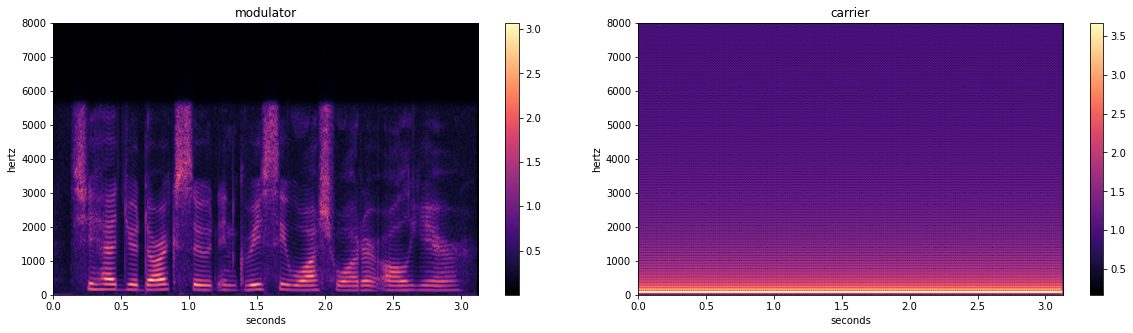

In [4]:
window = np.hanning(512)
modulator_stft = stft(modulator, 512, 128, 16, window)
carrier_stft = stft(carrier, 512, 128, 16, window)

cmap = plt.cm.magma
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

for z, ax in zip([(modulator_stft, 'modulator', modulator, sr_modulator), (carrier_stft, 'carrier', carrier, sr_carrier)], axes):
    im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
    ax.set_title(z[1])
    ax.set_xlabel('seconds')
    ax.set_ylabel('hertz')
    fig.colorbar(im, ax=ax)

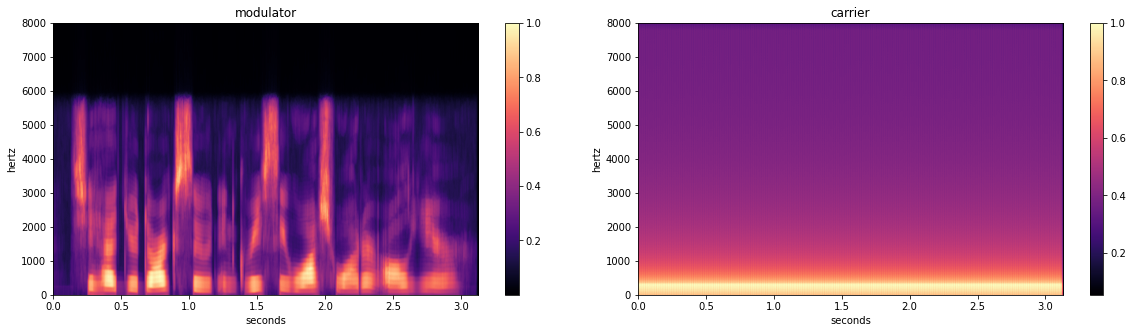

In [5]:
def compute_spectral_envelope(stft_matrix, smoothing_window_size, downsampling_factor):
    # Step 1: Compute the magnitude spectrum
    magnitude_spectrum = np.abs(stft_matrix)

    # Step 2: Smooth the magnitude spectrum
    window = np.ones(smoothing_window_size) / smoothing_window_size
    smoothed_spectrum = np.apply_along_axis(lambda m: np.convolve(m, window, mode='same'), axis=1, arr=magnitude_spectrum)

    # Step 3: Downsample the smoothed spectrum
    downsampled_spectrum = smoothed_spectrum[:, ::downsampling_factor]

    # Step 4: Interpolate the downsampled spectrum
    interpolated_spectrum = np.repeat(downsampled_spectrum, downsampling_factor, axis=1)

    # Step 5: Normalize the spectral envelope
    spectral_envelope = interpolated_spectrum / np.max(interpolated_spectrum)

    return spectral_envelope

modulator_envelope = compute_spectral_envelope(modulator_stft, smoothing_window_size=16, downsampling_factor=1)
carrier_envelope = compute_spectral_envelope(carrier_stft, smoothing_window_size=16, downsampling_factor=1)


cmap = plt.cm.magma
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

for z, ax in zip([(modulator_envelope, 'modulator', modulator, sr_modulator), (carrier_envelope, 'carrier', carrier, sr_carrier)], axes):
    im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
    ax.set_title(z[1])
    ax.set_xlabel('seconds')
    ax.set_ylabel('hertz')
    fig.colorbar(im, ax=ax)

In [6]:
carrier_divided = carrier_stft*carrier_envelope

In [7]:
print(carrier_divided)

[[-2.44408999e+00+0.00000000e+00j -7.48188066e+00-2.15462052e+00j
   4.39812222e+01+1.64854040e+01j ...  9.10097070e-03+2.44201308e-02j
  -1.68933088e-02-1.78621575e-03j  2.74478837e-02+0.00000000e+00j]
 [ 1.22866901e+00+0.00000000e+00j  3.33972681e+00+6.49270363e+00j
  -1.46582889e+01-4.16242225e+01j ...  1.06331314e-03-2.05434519e-02j
  -4.23194775e-03+2.50930254e-02j  3.53115147e-03+0.00000000e+00j]
 [ 1.17986032e+00+0.00000000e+00j  2.67392193e+00-6.61665055e+00j
  -2.40675162e+01+4.25728401e+01j ... -2.19398696e-02+1.71375708e-02j
   2.34364687e-02-1.30789534e-03j -2.40936521e-02+0.00000000e+00j]
 ...
 [-2.08292421e+00+0.00000000e+00j  6.87590573e-01+6.72993007e+00j
   1.15041626e+01-9.66948647e+00j ... -2.53259506e-03+2.37392219e-03j
  -2.31573975e-03+5.08165654e-03j  8.03459685e-03+0.00000000e+00j]
 [ 5.10080554e-01+0.00000000e+00j -1.75813236e-01-6.46100799e-01j
  -8.91345297e-01+1.88095418e-01j ... -6.30846147e-04-1.93297100e-04j
  -8.88268885e-05+5.93098352e-04j  5.39676916e-

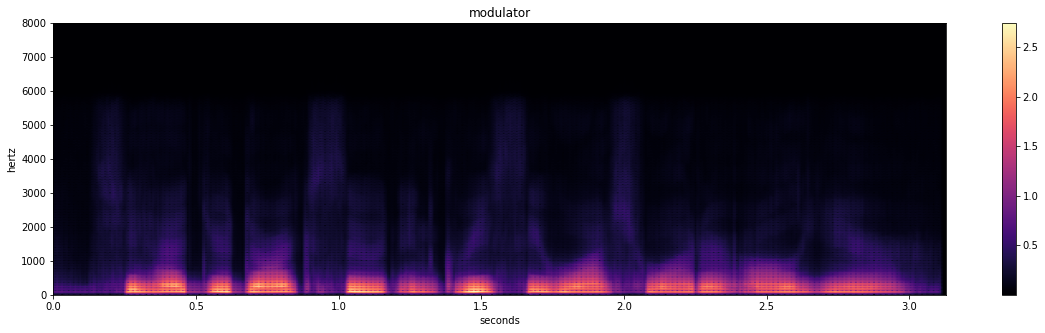

In [8]:
vocoded_stft = modulator_envelope * carrier_divided
cmap = plt.cm.magma
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
fig.subplots_adjust(wspace=0.1)

z = (vocoded_stft, 'modulator', modulator, sr_modulator)
im = ax.imshow(np.absolute(z[0].T)**0.3, cmap=cmap, origin='lower', extent=[0, len(z[2])/z[3], 0, 256*31.25], aspect="auto")
ax.set_title(z[1])
ax.set_xlabel('seconds')
ax.set_ylabel('hertz')
fig.colorbar(im, ax=ax)

In [9]:
window = np.hanning(512+16)
vocoded = istft(vocoded_stft, 512, 128, 16, window)
sound(vocoded, rate=sr_modulator)

""
